In [1]:
import os

import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SpatialDropout1D, LSTM, Conv1D, Dense, GlobalMaxPooling1D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from scipy import stats
import pickle

physical_devices = tf.config.list_physical_devices('GPU')
try:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  pass

In [2]:
input_data = pd.read_csv('time_series_covid19_confirmed_global.csv')
input_data = input_data[input_data['Country/Region'] == 'US']
input_data = input_data.drop(['Province/State', 'Country/Region', 'Lat', 'Long'], axis=1)
input_data = input_data.transpose()

In [3]:
# Scaling data
scaler = StandardScaler()
scaler.fit(input_data[:3*len(input_data)//4]) # 0.75 because train_size is 75% of given data
copy = scaler.transform(input_data)

timestep = 1

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()

    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]

    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]

    agg = pd.concat(cols, axis=1)
    agg.columns = names

    if dropnan:
        agg.dropna(inplace=True)   
        
    return agg

train = series_to_supervised(copy).values
print(np.array(train).shape)

(201, 2)


In [4]:
X_train = []
y_train = []

for i in range(timestep, len(input_data)-1):
    X_train.append(train[i-timestep:i, :len(input_data.columns)])
    y_train.append(train[i-timestep, len(input_data.columns):])
    
X_train, y_train = np.array(X_train), np.array(y_train)

data_dump = X_train, y_train

with open("./data.pickle","wb+") as pickle_out:
    pickle.dump(data_dump, pickle_out)

with open("./scaler.pickle","wb+") as pickle_out:
    pickle.dump(scaler, pickle_out)

In [5]:
with open("./data.pickle", "rb") as f:
    X_train, y_train = pickle.load(f)

In [6]:
model = Sequential()
model.add(LSTM(100, activation = 'tanh', recurrent_activation = 'sigmoid', recurrent_dropout = 0, unroll = False, use_bias = True, return_sequences = True, input_shape=(X_train.shape[1],X_train.shape[2])))
# model.add(LSTM(256, activation = 'tanh', recurrent_activation = 'sigmoid', recurrent_dropout = 0, unroll = False, use_bias = True, return_sequences = True))
model.add(GlobalMaxPooling1D())
model.add(Dense(128))
model.add(Dropout(0.25))
model.add(Dense(X_train.shape[2]))

model.compile(loss = 'mae', optimizer = Adam(lr = 1e-3))

In [7]:
# Model checkpoint callback to save model with lowest validation loss
cp_callbacks = ModelCheckpoint(filepath = "./model.h5", monitor = "val_loss", mode = 'min', save_best_only = True, verbose = 1)

# Fit model
history = model.fit(X_train, y_train, epochs = 90, batch_size = 256, validation_split = 0.25, callbacks = [cp_callbacks])

Epoch 1/90
1/1 [==============================] - ETA: 0s - loss: 0.8764
Epoch 00001: val_loss improved from inf to 3.57173, saving model to ./model.h5
1/1 [==============================] - 0s 402ms/step - loss: 0.8764 - val_loss: 3.5717
Epoch 2/90
1/1 [==============================] - ETA: 0s - loss: 0.8499
Epoch 00002: val_loss improved from 3.57173 to 3.49038, saving model to ./model.h5
1/1 [==============================] - 0s 59ms/step - loss: 0.8499 - val_loss: 3.4904
Epoch 3/90
1/1 [==============================] - ETA: 0s - loss: 0.8235
Epoch 00003: val_loss improved from 3.49038 to 3.40793, saving model to ./model.h5
1/1 [==============================] - 0s 49ms/step - loss: 0.8235 - val_loss: 3.4079
Epoch 4/90
1/1 [==============================] - ETA: 0s - loss: 0.7978
Epoch 00004: val_loss improved from 3.40793 to 3.32418, saving model to ./model.h5
1/1 [==============================] - 0s 57ms/step - loss: 0.7978 - val_loss: 3.3242
Epoch 5/90
1/1 [===================

Epoch 36/90
1/1 [==============================] - ETA: 0s - loss: 0.1137
Epoch 00036: val_loss did not improve from 0.03285
1/1 [==============================] - 0s 40ms/step - loss: 0.1137 - val_loss: 0.3729
Epoch 37/90
1/1 [==============================] - ETA: 0s - loss: 0.1041
Epoch 00037: val_loss did not improve from 0.03285
1/1 [==============================] - 0s 29ms/step - loss: 0.1041 - val_loss: 0.3303
Epoch 38/90
1/1 [==============================] - ETA: 0s - loss: 0.1023
Epoch 00038: val_loss did not improve from 0.03285
1/1 [==============================] - 0s 33ms/step - loss: 0.1023 - val_loss: 0.2784
Epoch 39/90
1/1 [==============================] - ETA: 0s - loss: 0.0864
Epoch 00039: val_loss did not improve from 0.03285
1/1 [==============================] - 0s 32ms/step - loss: 0.0864 - val_loss: 0.2191
Epoch 40/90
1/1 [==============================] - ETA: 0s - loss: 0.0776
Epoch 00040: val_loss did not improve from 0.03285
1/1 [==========================

Epoch 75/90
1/1 [==============================] - ETA: 0s - loss: 0.0445
Epoch 00075: val_loss did not improve from 0.03104
1/1 [==============================] - 0s 29ms/step - loss: 0.0445 - val_loss: 0.1144
Epoch 76/90
1/1 [==============================] - ETA: 0s - loss: 0.0447
Epoch 00076: val_loss did not improve from 0.03104
1/1 [==============================] - 0s 28ms/step - loss: 0.0447 - val_loss: 0.1142
Epoch 77/90
1/1 [==============================] - ETA: 0s - loss: 0.0413
Epoch 00077: val_loss did not improve from 0.03104
1/1 [==============================] - 0s 28ms/step - loss: 0.0413 - val_loss: 0.1135
Epoch 78/90
1/1 [==============================] - ETA: 0s - loss: 0.0477
Epoch 00078: val_loss did not improve from 0.03104
1/1 [==============================] - 0s 29ms/step - loss: 0.0477 - val_loss: 0.1266
Epoch 79/90
1/1 [==============================] - ETA: 0s - loss: 0.0399
Epoch 00079: val_loss did not improve from 0.03104
1/1 [==========================

In [8]:
model = tf.keras.models.load_model("./model.h5")

validation_target = y_train[3*len(X_train)//4:]
validation_predictions = []
error = []

# index of first validation input
i = 3*len(X_train)//4

while len(validation_predictions) < len(validation_target) - 1:
  p = model.predict(X_train[i].reshape(1, X_train.shape[1], X_train.shape[2]))[0] 
  i += 1
  error.append(mean_absolute_error(p,y_train[i]))

  # update the predictions list
  validation_predictions.append(p)

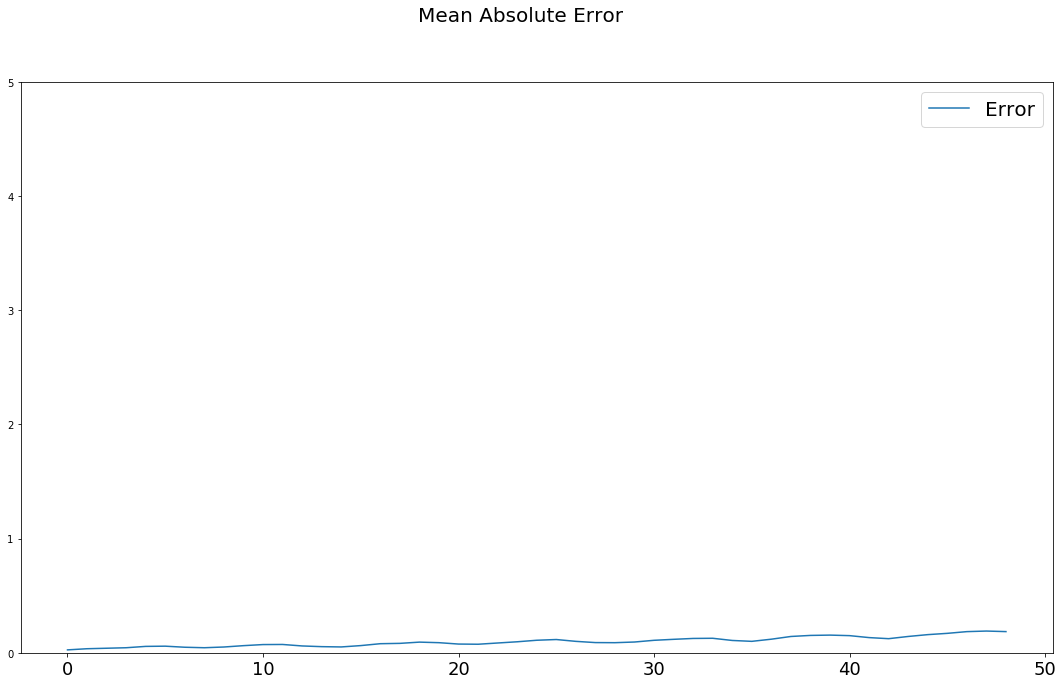

In [9]:
fig = plt.figure()
fig.set_size_inches(18.5, 10.5)
fig.suptitle('Mean Absolute Error', size=20)
plt.plot(error, label='Error')
plt.xticks(fontsize=18)
plt.ylim(0, 5)
plt.legend(prop={'size': 20})
plt.show()

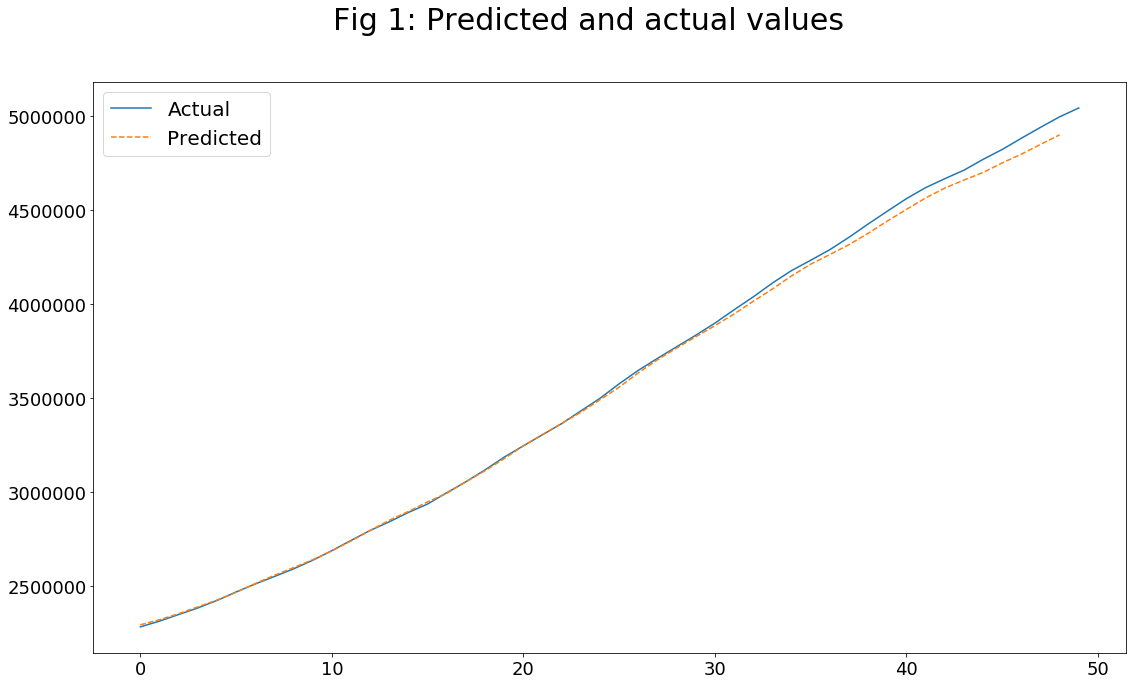

In [10]:
with open('./scaler.pickle', 'rb') as f:
    scaler = pickle.load(f)
    
for i in range(validation_target.shape[1]):
    fig = plt.figure()
    fig.set_size_inches(18.5, 10.5)
    fig.suptitle("Fig "+str(i+1)+": Predicted and actual values ", size=30)
    plt.plot(scaler.inverse_transform(validation_target)[:, i], label='Actual')
    plt.plot(scaler.inverse_transform(np.array(validation_predictions))[:, i], '--', label='Predicted')
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.legend(prop={'size': 20})
    plt.show()